# [Self RAG](https://blog.langchain.dev/agentic-rag-with-langgraph/)

Self-RAG is a strategy for RAG that incorporates self-reflection / self-grading on retrieved documents and generations.

In the [paper](https://arxiv.org/abs/2310.11511), a few decisions are made:

1. Should I retrieve from retriever, `R` -

* Input: `x (question)` OR `x (question)`, `y (generation)`
* Decides when to retrieve `D` chunks with `R`
* Output: `yes, no, continue`

2. Are the retrieved passages `D` relevant to the question `x` -

* * Input: (`x (question)`, `d (chunk)`) for `d` in `D`
* `d` provides useful information to solve `x`
* Output: `relevant, irrelevant`

3. Are the LLM generation from each chunk in `D` is relevant to the chunk (hallucinations, etc)  -

* Input: `x (question)`, `d (chunk)`,  `y (generation)` for `d` in `D`
* All of the verification-worthy statements in `y (generation)` are supported by `d`
* Output: `{fully supported, partially supported, no support`

4. The LLM generation from each chunk in `D` is a useful response to `x (question)` -

* Input: `x (question)`, `y (generation)` for `d` in `D`
* `y (generation)` is a useful response to `x (question)`.
* Output: `{5, 4, 3, 2, 1}`

We will implement some of these ideas from scratch using [LangGraph](https://python.langchain.com/docs/langgraph).



# Environment

In [22]:
import os

In [23]:
# workaround https://stackoverflow.com/questions/54382643/colab-suddenly-unable-to-navigate-through-directories

os.chdir('/content')

In [24]:
!pip install langchain_community langchainhub chromadb langchain langgraph langsmith langchain_google_vertexai

In [78]:
from langchain.globals import set_debug

In [79]:
set_debug(False)

### Setup

#### Setup GCP and VertexAI

In [25]:
from google.colab import auth

In [26]:
import vertexai

PROJECT_ID='langgraph-graded-rag'
REGION_ID='us-central1'

TEXT_EMBEDDING_MODEL = 'textembedding-gecko'
LLM_MODEL = "gemini-1.0-pro"

In [27]:
auth.authenticate_user(project_id=PROJECT_ID)

In [28]:
vertexai.init(project=PROJECT_ID, location=REGION_ID)

### Tracing

Optionally, use [LangSmith](https://docs.smith.langchain.com/) for tracing (shown at bottom)

In [29]:
import os

os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = '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'

## Retriever grading

In [30]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
# from langchain_openai import ChatOpenAI
from langchain_google_vertexai import ChatVertexAI

### Setup retriever

Let's index 3 blog posts.

In [31]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
# from langchain_openai import OpenAIEmbeddings
from langchain_google_vertexai import VertexAIEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Skip tiktoken encoder as we're using VertexAIEmbeddings
# text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
#     chunk_size=250, chunk_overlap=0
# )
text_splitter = RecursiveCharacterTextSplitter(chunk_size=250, chunk_overlap=0)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=VertexAIEmbeddings(model_name=TEXT_EMBEDDING_MODEL),
)
retriever = vectorstore.as_retriever()

#### Structure LLM output to enable grading

In [32]:
# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

In [33]:
# LLM with function call
# llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
llm = ChatVertexAI(model=LLM_MODEL, temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

#### Setup prompt & chain for retriever grading

In [34]:
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

#### Invoke chain and perform grading

In [35]:
question = "agent memory"
# get_relevant_documents is deprecated
# docs = retriever.get_relevant_documents(question)
docs = retriever.invoke(question)
print(docs)
doc_txt = docs[1].page_content
score = retrieval_grader.invoke({"question": question, "document": doc_txt})
print(f"Score: {score} for question: '{question}' and document: '{doc_txt}'")
print(score.binary_score)

[Document(page_content='Memory stream: is a long-term memory module (external database) that records a comprehensive list of agents’ experience in natural language.', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log"}), Document(page_content='Memory stream: is a long-term memory module (external database) that records a comprehensive list of agents’ experience in natural language.', metadata=

## Hallucination grading

### Setup generation reusing `docs` retrieved for `question`

In [36]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
# llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
llm = ChatVertexAI(model=LLM_MODEL, temperature=0)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

Agent memory is a long-term memory module that records a comprehensive list of agents' experiences in natural language. It provides the agent with the capability to retain and recall information over extended periods. This information is often stored in an external vector store and retrieved quickly. 


#### Structure LLM output to enable grading

In [37]:
# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

In [38]:
# llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
llm = ChatVertexAI(model=LLM_MODEL, temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

#### Setup prompt & chain for hallucination grading

In [39]:
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
print(hallucination_grader.invoke({"documents": docs, "generation": generation}))

binary_score='yes'


## Answer grading

### Structure LLM output to enable grading

In [40]:
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

In [41]:
# LLM with function call
# llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
llm = ChatVertexAI(model=LLM_MODEL, temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

### Setup prompt & chain for answer grading


In [42]:
system = """You are a grader assessing whether an answer addresses / resolves a question \n
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
print(answer_grader.invoke({"question": question, "generation": generation}))

None


## Question Re-writer

In [43]:
# LLM
# llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
llm = ChatVertexAI(model=LLM_MODEL, temperature=0)

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Here is the initial question: \n\n {question} \n Formulate an improved question.",),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
print(question_rewriter.invoke({"question": question}))

Here is an improved question:

What is agent memory and how does it work?


# Graph

Capture the flow in as a graph.

### Imports

In [44]:
from typing_extensions import TypedDict
from typing import List

from langchain.schema import Document

### Graph state

- question
- generation
- documents

In [45]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

### Graph nodes

- Nodes accept a graph state and return a graph state
- Nodes could use a chain with an llm, vectordb etc to do some work to update graph state


### Constants

- To minimize brittleness in using strings for node names
- TODO: better way to map node names to functions for nodes

In [46]:
# nodes
RETRIEVE_DOCS_NODE="retrieve_docs"
GENERATE_ANS_NODE="generate_ans"
GRADE_AND_FILTER_DOCS_NODE="grade_and_filter_docs"
REWRITE_QUESTION_NODE="rewrite_question"

# decisions
NO_RELEVANT_DOCS_SHOULD_REWRITE_QUESTION="no_relevant_docs_should_rewrite_question"
HAS_RELEVANT_DOCS_SHOULD_GENERATE_ANSWER="have_relevant_docs_should_generate_ans"
RETRIEVE_DECISION="decision_retrieve" # not used
GRADE_DECISION="decision_grade"       # not used


# verdicts
ANSWER_SUPPORTED_AND_USEFUL_VERDICT="ans_supported_and_useful"
ANSWER_SUPPORTED_BUT_NOT_USEFUL_VERDICT="ans_supported_but_not_useful"
ANSWER_HALLUCINATION_NOT_SUPPORTED_BY_DOCS_VERDICT="ans_hallucination_not_supported_by_docs"

#### Retrieval node

- Input: `question` graph state
- Ouput: `documents` graph state with associated `question` graph state

In [80]:
# Constant: RETRIEVE_DOCS_NODE

def retrieve_docs(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    # print("---RETRIEVE DOCS---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}

### Generation node

- Input: `question` graph state with ssociated RAG `documents` graph state
- Output: `question`, `documents` with associated LLM `generation`

In [81]:
# Constant: GENERATE_ANS_NODE

def generate_ans(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    # print("---GENERATE ANS---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

### Grading node

- Input: `question` and `documents` graph state
- Output: `question` and `documents` graph state, where documents in input that fail retrieval grading are filtered out

In [83]:
# Constant: GRADE_AND_FILTER_DOCS_NODE

def grade_and_filter_docs(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    # print("---GRADE DOCUMENTS RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        # DEBUG
        # print(f"retrieval_grader score: '{score}' for question: '{question}' and document: '{d.page_content}'")
        # TODO: sometimes llm doesn't structure output to have a binary_score
        if score is None:
          # print("---GRADE: NONE. DOCUMENT IS NOT RELEVANT TO QUESTION---")
          continue
        if score.binary_score == "yes":
          # print("---GRADE: YES. DOCUMENT IS RELEVANT TO QUESTION---")
          filtered_docs.append(d)
        # else:
          # print("---GRADE: NO. DOCUMENT IS NOT RELEVANT TO QUESTION---")

    return {"documents": filtered_docs, "question": question}

### Rewrite question node

- Input: `question` and `documents` graph state
- Output: rewritten `question` and `documents` graph state using question rewriter

In [84]:
# Constant: REWRITE_QUESTION_NODE

def rewrite_question(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    # print("---REWRITE QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

## Graph edges

### Evaluate graded docs against question and return a decision

- Input: dict of current graph state
- Output: Decision: `TRANSFORM_DECISION` or `GENERATE_DECISION`

Based on question vs documents graph state after filtering out by retrieval grading


In [85]:
def eval_graded_docs_v_question(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    # print("---CHECK FOR FILTERED DOCUMENTS---")
    question = state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        # print("---DECISION: NO DOCUMENTS RELEVANT TO QUESTION, REWRITE QUESTION---")
        return NO_RELEVANT_DOCS_SHOULD_REWRITE_QUESTION
    else:
        # We have relevant documents, so generate answer
        # print("---DECISION: HAVE RELEVANT DOCUMENTS, GENERATE ANSWER---")
        return HAS_RELEVANT_DOCS_SHOULD_GENERATE_ANSWER

### Grade docs against question and answer against docs and return verdicts
- Input: dict of graph state
- Output: Verdict

Based on hallucination grade of generation vs. documents, verdics are:
  - If no hallucination, answer grade of question vs. generation:
    - `ANSWER_SUPPORTED_AND_USEFUL_VERDICT` if passsed answer grading
    - `ANSWER_SUPPORTED_BUT_NOT_USEFUL_VERDICT` if fails answer grading
  - If yes hallucination, `ANSWER_HALLUCINATION_NOT_SUPPORTED_BY_DOCS_VERDICT`



In [86]:
def grade_answer_v_documents_and_question(state):
    """
    Determines whether the gen answer is grounded in the document and
    answers the question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    # print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )

    # Check hallucination

    # TODO: sometimes llm doesn't structure output to have a binary_score
    # grade = score.binary_score
    # DEBUG
    # print(f"hallucination_grader: '{score}' for grounding '{generation}' in documents: '{documents}'")

    if score is None:
      # pprint("---DECISION: NO SCORE. GENERATION POSSIBLY NOT GROUNDED IN DOCUMENTS, RE-TRY---")
      return ANSWER_HALLUCINATION_NOT_SUPPORTED_BY_DOCS_VERDICT

    if score.binary_score == "yes":
        # print("---DECISION: YES. GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        # print("---GRADE ANSWER GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        # TODO: sometimes llm doesn't structure output to have a binary_score
        # grade = score.binary_score

        # DEBUG
        # print(f"answer_grader score: '{score}' for whether '{generation}' answers question: '{question}'")

        if score is None:
          # print("---DECISION: NO SCORE. ANSWER DOES NOT ADDRESS QUESTION---")
          return ANSWER_SUPPORTED_BUT_NOT_USEFUL_VERDICT

        if score.binary_score == "yes":
            # print("---DECISION: YES. ANSWER ADDRESSES QUESTION---")
            return ANSWER_SUPPORTED_AND_USEFUL_VERDICT
        else:
            # print("---DECISION: NO. ANSWER DOES NOT ADDRESS QUESTION---")
            return ANSWER_SUPPORTED_BUT_NOT_USEFUL_VERDICT

## Build Graph

The just follows the flow we outlined in the figure above.

In [87]:
from langgraph.graph import END, StateGraph

#### A workflow is a graph of state transitions

In [88]:
workflow = StateGraph(GraphState)

#### 4 Nodes represent the workflow state machine

In [89]:
# 4 nodes
workflow.add_node(RETRIEVE_DOCS_NODE, retrieve_docs)
workflow.add_node(GRADE_AND_FILTER_DOCS_NODE, grade_and_filter_docs)
workflow.add_node(GENERATE_ANS_NODE, generate_ans)
workflow.add_node(REWRITE_QUESTION_NODE, rewrite_question)

### Edges describe how state transitions from one state to another state

In [90]:
# 4 edges

# Edge 1: retrieval node -> grading node
# always transition state to grade docs after retrieving
workflow.add_edge(RETRIEVE_DOCS_NODE, GRADE_AND_FILTER_DOCS_NODE)

# Edge 2: grading node -> transform_query node |  generate node
# conditionally transition state based on eval_graded_docs_v_question
workflow.add_conditional_edges(
    GRADE_AND_FILTER_DOCS_NODE,
    eval_graded_docs_v_question,
    {
        NO_RELEVANT_DOCS_SHOULD_REWRITE_QUESTION: REWRITE_QUESTION_NODE,
        HAS_RELEVANT_DOCS_SHOULD_GENERATE_ANSWER: GENERATE_ANS_NODE,
    },
)

# Edge 3: rewrite question node -> retrieve docs node
# always transition state to retrieve docs after rewriting question
workflow.add_edge(REWRITE_QUESTION_NODE, RETRIEVE_DOCS_NODE)

# Edge 4: generate node -> generate node | rewrite question node | END
# conditionally transition state based on grade_generation_v_documents_and_question
workflow.add_conditional_edges(
    GENERATE_ANS_NODE,
    grade_answer_v_documents_and_question,
    {
        ANSWER_SUPPORTED_AND_USEFUL_VERDICT: END,
        ANSWER_SUPPORTED_BUT_NOT_USEFUL_VERDICT: REWRITE_QUESTION_NODE,
        ANSWER_HALLUCINATION_NOT_SUPPORTED_BY_DOCS_VERDICT: GENERATE_ANS_NODE
    },
)

#### Workflow starts at the retrieval state

In [91]:
# start
workflow.set_entry_point(RETRIEVE_DOCS_NODE)

#### Workflow graph of nodes and edges is finally compiled

In [92]:
# compile
app = workflow.compile()

## Visualize Graph

### Mermaid text

In [93]:
print(app.get_graph().draw_mermaid())

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__[__start__]:::startclass;
	__end__[__end__]:::endclass;
	retrieve_docs([retrieve_docs]):::otherclass;
	grade_and_filter_docs([grade_and_filter_docs]):::otherclass;
	generate_ans([generate_ans]):::otherclass;
	rewrite_question([rewrite_question]):::otherclass;
	__start__ --> retrieve_docs;
	retrieve_docs --> grade_and_filter_docs;
	rewrite_question --> retrieve_docs;
	grade_and_filter_docs -. no_relevant_docs_should_rewrite_question .-> rewrite_question;
	grade_and_filter_docs -. have_relevant_docs_should_generate_ans .-> generate_ans;
	generate_ans -. ans_supported_and_useful .-> __end__;
	generate_ans -. ans_supported_but_not_useful .-> rewrite_question;
	generate_ans -. ans_hallucination_not_supported_by_docs .-> generate_ans;
	classDef startclass fill:#ffdfba;
	classDef endclass fill:#baffc9;
	classDef otherclass fill:#fad7de;



### Mermaid PNG

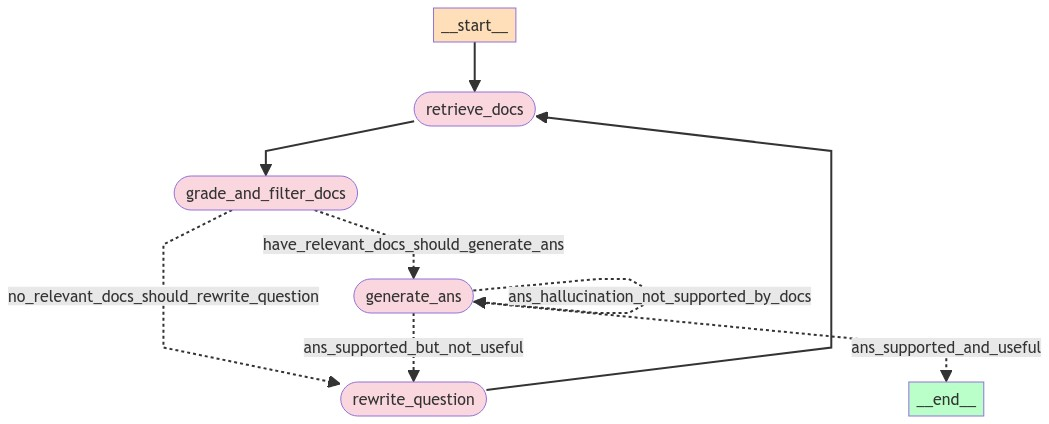

In [94]:
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod
from IPython.display import display, HTML, Image

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Run Graph

In [103]:
from langgraph.pregel import GraphRecursionError
from langchain_core.runnables import RunnableConfig

In [127]:
def run_graph(question, limit=10):
  inputs = {"question": question}
  config = RunnableConfig(recursion_limit=limit)
  try:
    result = app.invoke(inputs, config)
    return result['generation']
  except GraphRecursionError:
    return "Sorry I can't answer that yet. Is there anything else I can help you with?"

In [129]:
%%time

answer = run_graph('agent memory', 25)
print(answer)

Language models leverage agent memory to improve their performance in tasks like question answering, summarization, and dialogue generation by retaining and recalling information over extended periods. This allows them to access relevant context and provide more accurate and consistent responses. For example, in question answering, an agent with memory can access previous questions and answers to provide more relevant and informative responses. 

CPU times: user 1.51 s, sys: 140 ms, total: 1.65 s
Wall time: 46.4 s


In [130]:
%%time

answer = run_graph('Explain how chain of thought prompting works?', 25)
print(answer)

Sorry I can't answer that yet. Is there anything else I can help you with?
CPU times: user 1.66 s, sys: 138 ms, total: 1.8 s
Wall time: 46 s
